<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [60]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [61]:
import tensorflow as tf

# Verifica si TensorFlow está utilizando GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Verifica los dispositivos disponibles y sus detalles
for device in tf.config.list_physical_devices():
    print(device)

Num GPUs Available:  1
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Datos

Utilizo el libro **Harry Potter y La piedra filosofal**, de la autora J.K. Rowling para entrenar el modelo, de manera tal que la predicción de la palabra va a estar relacionada con el contexto de la historia dada en el libro.

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
# Path donde va a estar el libro en Colab

filepath = r"drive/MyDrive/Colab Notebooks/Book1.txt"
#filepath = 'Book1.txt' #local

In [6]:
import re

# leo el archivo local
with open(filepath, 'r', encoding='utf-8') as file:
    article_text = file.read()

# paso todo el texto a minúsculas
article_text = article_text.lower()

# elimino caracteres especiales y números, manteniendo solo texto y espacios
article_text = re.sub(r'\s+', ' ', article_text)
article_text = article_text.replace('/', '')


In [7]:
# en article text se encuentra el texto de todo el libro
print(article_text[:1000])

 the boy who lived mr. and mrs. dursley, of number four, privet drive, were proud to say that they were perfectly normal, thank you very much. they were the last people you’d expect to be involved in anything strange or mysterious, because they just didn’t hold with such nonsense. mr. dursley was the director of a firm called grunnings, which made drills. he was a big, beefy man with hardly any neck, although he did have a very large mustache. mrs. dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors. the dursley s had a small son called dudley and in their opinion there was no finer boy anywhere. the dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. they didn’t think they could bear it if anyone found out about the potters. mrs. potter was mrs. dursley’s sister, but they hadn’t p

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [8]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [9]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [10]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [11]:
# la longitud de vocabulario de caracteres es:
print(f"La longitud de vocabulario de caracteres es: {len(chars_vocab)}")

La longitud de vocabulario de caracteres es: 57


In [12]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [13]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [14]:
tokenized_text[:1000]

[54,
 12,
 4,
 27,
 54,
 7,
 39,
 33,
 54,
 9,
 4,
 39,
 54,
 1,
 26,
 31,
 27,
 43,
 54,
 19,
 28,
 53,
 54,
 0,
 10,
 43,
 54,
 19,
 28,
 24,
 53,
 54,
 43,
 23,
 28,
 24,
 1,
 27,
 33,
 41,
 54,
 39,
 52,
 54,
 10,
 23,
 19,
 7,
 27,
 28,
 54,
 52,
 39,
 23,
 28,
 41,
 54,
 20,
 28,
 26,
 31,
 27,
 12,
 54,
 43,
 28,
 26,
 31,
 27,
 41,
 54,
 9,
 27,
 28,
 27,
 54,
 20,
 28,
 39,
 23,
 43,
 54,
 12,
 39,
 54,
 24,
 0,
 33,
 54,
 12,
 4,
 0,
 12,
 54,
 12,
 4,
 27,
 33,
 54,
 9,
 27,
 28,
 27,
 54,
 20,
 27,
 28,
 52,
 27,
 50,
 12,
 1,
 33,
 54,
 10,
 39,
 28,
 19,
 0,
 1,
 41,
 54,
 12,
 4,
 0,
 10,
 55,
 54,
 33,
 39,
 23,
 54,
 31,
 27,
 28,
 33,
 54,
 19,
 23,
 50,
 4,
 53,
 54,
 12,
 4,
 27,
 33,
 54,
 9,
 27,
 28,
 27,
 54,
 12,
 4,
 27,
 54,
 1,
 0,
 24,
 12,
 54,
 20,
 27,
 39,
 20,
 1,
 27,
 54,
 33,
 39,
 23,
 6,
 43,
 54,
 27,
 56,
 20,
 27,
 50,
 12,
 54,
 12,
 39,
 54,
 7,
 27,
 54,
 26,
 10,
 31,
 39,
 1,
 31,
 27,
 43,
 54,
 26,
 10,
 54,
 0,
 10,
 33,
 12,
 4,
 26,
 

### Organizando y estructurando el dataset

In [15]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [16]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [17]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [18]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [19]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [20]:
X.shape

(413063, 100)

In [21]:
X[0,:10]

array([54, 12,  4, 27, 54,  7, 39, 33, 54,  9])

In [22]:
y[0,:10]

array([12,  4, 27, 54,  7, 39, 33, 54,  9,  4])

In [23]:
vocab_size = len(chars_vocab)
print("Vocab size:", vocab_size)

Vocab size: 57


# Definiendo el modelo

In [24]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense, GRU
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

Sumado al modelo original propuesto en clases, voy a crear dos modelos adicionales: LSTM y GRU. Dada la experiencia pasada y el gran coste computacional de entrenar estos modelos, se utilizarán menos conexiones en las capas para su entrenamiento.

### Modelo simpleRNN

In [25]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, None, 57)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, None, 200)           │          51,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 57)            │          11,457 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,057 (246.32 KB)

 Trainable params: 63,057 (246.32 KB)

 Non-trainable params: 0 (0.00 B)

### Modelo LSTM

In [26]:
model_lstm = Sequential()

model_lstm.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_lstm.add(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_lstm.add(Dense(vocab_size, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_1 (TimeDistributed) │ (None, None, 57)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 100)           │          63,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 57)            │           5,757 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,957 (269.36 KB)

 Trainable params: 68,957 (269.36 KB)

 Non-trainable params: 0 (0.00 B)

### Modelo GRU

In [27]:
model_gru = Sequential()

model_gru.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_gru.add(GRU(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_gru.add(Dense(vocab_size, activation='softmax'))
model_gru.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_2 (TimeDistributed) │ (None, None, 57)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, None, 100)           │          47,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 57)            │           5,757 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,457 (208.82 KB)

 Trainable params: 53,457 (208.82 KB)

 Non-trainable params: 0 (0.00 B)


### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [28]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5, model_name='best_model'):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience
      self.model_name = model_name
      self.history_ppl = history_ppl

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          save_path = f'drive/MyDrive/Colab Notebooks/desafio_3/{self.model_name}.keras'
          self.model.save(save_path) #my_model.h5
          print(f"Saved new model: {self.model_name}.keras")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

#### Entrenamiento simpleRNN

In [ ]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl, model_name='model_simpleRNN')], batch_size=256)

Epoch 1/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.3534
 mean perplexity: 5.589537286103571 

Saved new model: model_simpleRNN.keras
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 61s 34ms/step - loss: 2.3533
Epoch 2/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7906
 mean perplexity: 4.885896100435235 

Saved new model: model_simpleRNN.keras
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 46s 28ms/step - loss: 1.7906
Epoch 3/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6876
 mean perplexity: 4.729709749915466 

Saved new model: model_simpleRNN.keras
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 46s 28ms/step - loss: 1.6876
Epoch 4/20
1611/1614 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6464
 mean perplexity: 4.648607036571634 

Saved new model: model_simpleRNN.keras
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 46s 28ms/step - loss: 1.6464
Epoch 5/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6211
 mean perplexity: 4.530915772601736 

Saved new model: model_simpleRNN.keras
1614/1614 ━━━━━━━━━━━━━━━

#### Entrenamiento LSTM

In [ ]:
history_ppl_lstm = []
hist_lstm = model_lstm.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_lstm, model_name='model_lstm')], batch_size=256)

Epoch 1/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 2.7263
 mean perplexity: 8.586886073555608 

Saved new model: model_lstm.keras
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 244s 147ms/step - loss: 2.7262
Epoch 2/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 2.1833
 mean perplexity: 7.1592440669760835 

Saved new model: model_lstm.keras
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 235s 146ms/step - loss: 2.1833
Epoch 3/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 2.0375
 mean perplexity: 6.3657185465364545 

Saved new model: model_lstm.keras
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 235s 146ms/step - loss: 2.0375
Epoch 4/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 1.9487
 mean perplexity: 5.88493669165991 

Saved new model: model_lstm.keras
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 234s 145ms/step - loss: 1.9487
Epoch 5/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 1.8925
 mean perplexity: 5.591976333933238 

Saved new model: model_lstm.keras
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 232s 144ms

#### Entrenamiento GRU

In [ ]:
history_ppl_GRU = []
hist_gru = model_gru.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_GRU, model_name='model_gru')], batch_size=256)

Epoch 1/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 2.5035
 mean perplexity: 5.84204279590027 

Saved new model: model_gru.keras
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 331s 202ms/step - loss: 2.5033
Epoch 2/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 1.8259
 mean perplexity: 5.02090861294786 

Saved new model: model_gru.keras
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 324s 201ms/step - loss: 1.8259
Epoch 3/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 1.7115
 mean perplexity: 4.732996954623499 

Saved new model: model_gru.keras
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 329s 204ms/step - loss: 1.7115
Epoch 4/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 1.6615
 mean perplexity: 4.667749585836112 

Saved new model: model_gru.keras
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 324s 201ms/step - loss: 1.6615
Epoch 5/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 1.6316
 mean perplexity: 4.615972640204875 

Saved new model: model_gru.keras
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 324s 201ms/st

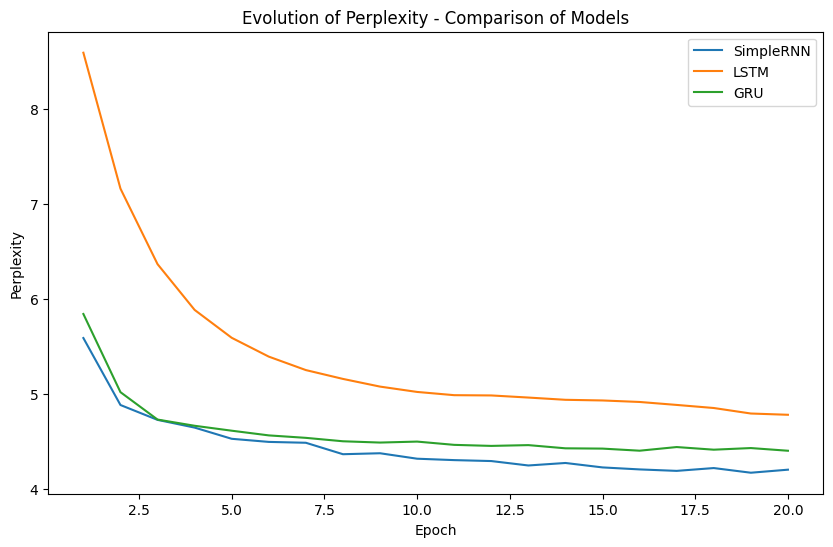

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener la longitud máxima entre los tres history_ppl
max_epochs = max(len(history_ppl), len(history_ppl_lstm), len(history_ppl_GRU))

# Rellenar con NaN para igualar las longitudes
history_ppl_vector = np.pad(history_ppl, (0, max_epochs - len(history_ppl)), 'constant', constant_values=np.nan)
history_ppl_lstm_vector = np.pad(history_ppl_lstm, (0, max_epochs - len(history_ppl_lstm)), 'constant', constant_values=np.nan)
history_ppl_gru_vector = np.pad(history_ppl_GRU, (0, max_epochs - len(history_ppl_GRU)), 'constant', constant_values=np.nan)

epoch_count = range(1, max_epochs + 1)

# Graficar con todas las épocas, usando NaN para los valores faltantes
plt.figure(figsize=(10, 6))
sns.lineplot(x=epoch_count, y=history_ppl_vector, label="SimpleRNN")
sns.lineplot(x=epoch_count, y=history_ppl_lstm_vector, label="LSTM")
sns.lineplot(x=epoch_count, y=history_ppl_gru_vector, label="GRU")

# Etiquetas y título
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Evolution of Perplexity - Comparison of Models')

# Mostrar leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

El gráfico muestra que el modelo SimpleRNN alcanzó la menor perplejidad al final del entrenamiento, superando a LSTM y GRU en este aspecto. Sin embargo, es importante notar las diferencias en las trayectorias de aprendizaje de los tres modelos.

- LSTM comenzó con la perplejidad más alta pero mostró la mejora más dramática en las primeras épocas, lo que sugiere un potencial significativo para el aprendizaje. Aunque terminó con la perplejidad más alta entre los tres modelos, su curva de aprendizaje indica que podría beneficiarse de un entrenamiento más prolongado o de un ajuste de hiperparámetros.

- GRU mostró un rendimiento intermedio, acercándose mucho al SimpleRNN en las últimas épocas. Su curva de aprendizaje más suave sugiere una mayor estabilidad durante el entrenamiento, lo que podría ser una ventaja en ciertos escenarios.

- Tanto LSTM como GRU se implementaron con menos unidades recurrentes (100) en comparación con SimpleRNN (200), dado el coste computacional que representaba. Esto implica que el potencial completo de LSTM y GRU podría no haberse alcanzado

- En cuanto a la eficiencia computacional, SimpleRNN demostró ser el más rápido en entrenamiento, lo cual es esperado dada su arquitectura más simple. LSTM y GRU, siendo modelos más complejos, requirieron más tiempo de entrenamiento.



### Predicción del próximo caracter

In [77]:
# Procedo a cargar todos los modelos guardados
# Esto puede variar entre drive y el github local

model_simpleRNN = keras.models.load_model('drive/MyDrive/Colab Notebooks/desafio_3/model_simpleRNN.keras')
model_LSTM = keras.models.load_model('drive/MyDrive/Colab Notebooks/desafio_3/model_lstm.keras')
model_GRU = keras.models.load_model('drive/MyDrive/Colab Notebooks/desafio_3/model_gru.keras')


In [40]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.9 MB/s eta 0:00:00


In [44]:
import gradio as gr

def model_response(human_text, model=model_simpleRNN):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://a15bd48b7439d0b4c7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a15bd48b7439d0b4c7.gradio.live


A continuación voy a poner una ejecución por medio de la salida de la funcion "model response" de forma de dejar acentado el valor de la predicción.

Para ello dejo 3 casos donde:

1. Probamos "albu" en referencia a Albus Dumbledore, y vemos que podria no ser trivial la respuesta siendo por ejemplo "album"
2. Una frase que finaliza en "qui" siendo que se busca la palabra "quidditch" en referencia al popular deporte
3. La misma frase que el item anterior, pero siendo "quid"

In [45]:
# Prueba del modelo:

test_string = "albu"
print(f'Modelo SimpleRNN: { model_response(test_string, model_LSTM) }')
print(f'Modelo LSTM: {model_response(test_string, model_simpleRNN)}')
print(f'Modelo GRU: {model_response(test_string, model_GRU)}')



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Modelo SimpleRNN: albut
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Modelo LSTM: albus
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Modelo GRU: albus


In [47]:
test_string_2 = "Harry's broomstick was the best in the qui"
print("PALABRA CON MAS CONTEXTO")
print(f'Modelo SimpleRNN: { model_response(test_string_2, model_LSTM) }')
print(f'Modelo LSTM: {model_response(test_string_2, model_simpleRNN)}')
print(f'Modelo GRU: {model_response(test_string_2, model_GRU)}')

PALABRA CON MAS CONTEXTO
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Modelo SimpleRNN: Harry's broomstick was the best in the quir
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Modelo LSTM: Harry's broomstick was the best in the quid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Modelo GRU: Harry's broomstick was the best in the quid


In [48]:
test_string_2 = "Harry's broomstick was the best in the quid"
print("PALABRA CON MAS CONTEXTO")
print(f'Modelo SimpleRNN: { model_response(test_string_2, model_LSTM) }')
print(f'Modelo LSTM: {model_response(test_string_2, model_simpleRNN)}')
print(f'Modelo GRU: {model_response(test_string_2, model_GRU)}')

PALABRA CON MAS CONTEXTO
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Modelo SimpleRNN: Harry's broomstick was the best in the quidd
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Modelo LSTM: Harry's broomstick was the best in the quidd
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Modelo GRU: Harry's broomstick was the best in the quidd


En esta prueba evaluamos los 3 modelos (SimpleRNN, LSTM y GRU) utilizando diferentes frases incompletas para observar cómo completan las palabras según el contexto.

Prueba con "albu"

- El Modelo SimpleRNN completó incorrectamente la palabra como "albut", lo cual es una predicción fallida.
- Tanto el Modelo LSTM como el Modelo GRU lograron completar correctamente la palabra como "albus", lo que refleja una mejor capacidad para capturar el contexto en esta prueba.

Pruebas con **Harry's broomstick was the best in the qui**:

- El Modelo SimpleRNN generó "quir", lo cual es incorrecto al contexto aplicado y los demas logrron completar correctamente con "quid" que era esperado

Prueba con **Harry's broomstick was the best in the quid**:

- Todos los modelos (SimpleRNN, LSTM, GRU) predijeron correctamente la continuación "quidd"


El SimpleRNN mostró dificultades para completar correctamente las palabras en las pruebas, lo cual es coherente con sus limitaciones para capturar dependencias a largo plazo.
Tanto el LSTM como el GRU completaron de manera más precisa en ambas pruebas, mostrando su capacidad para manejar mejor el contexto en la generación de texto.

### Generación de secuencias

In [49]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [52]:
input_text='Harry, Ron and Hermione were in'

print("GENERACIÓN DE SECUENCIAS")
print('Modelo SimpleRNN:')
print(generate_seq(model_simpleRNN, input_text, max_length=max_context_size, n_words=30))

print('Modelo LSTM:')
print(generate_seq(model_LSTM, input_text, max_length=max_context_size, n_words=30))

print('Modelo GRU:')
print(generate_seq(model_GRU, input_text, max_length=max_context_size, n_words=30))

GENERACIÓN DE SECUENCIAS
Modelo SimpleRNN:
Harry, Ron and Hermione were in the dursleys were the stone -
Modelo LSTM:
Harry, Ron and Hermione were in the started the starts and th
Modelo GRU:
Harry, Ron and Hermione were in the stone of the stone of the


En las pruebas de generación de secuencias con el texto inicial "Harry, Ron and Hermione were in":

- Modelo SimpleRNN: Produjo una salida confusa y menos coherente: "the dursleys were the stone -".
- Modelo LSTM: Generó una secuencia más coherente que el SimpleRNN, pero con fragmentos poco lógicos: "the started the starts and th".
- Modelo GRU: tiene la salida más relevante y fluida: "the stone of the stone of the", mostrando una mejor comprensión del contexto.

###  Beam search y muestreo aleatorio

In [53]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [54]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [81]:
# predicción con beam search en modo determinista
string_to_search = "harry, ron and hermione were in"
print(f"Modelo SimpleRNN: {decode(beam_search(model_simpleRNN,num_beams=10,num_words=20,input=string_to_search,temp=1,mode='det')[0])}")
print(f'Modelo LSTM: {decode(beam_search(model_LSTM,num_beams=10,num_words=20,input=string_to_search,temp=1,mode="det")[0])}')
print(f'Modelo GRU: {decode(beam_search(model_GRU,num_beams=10,num_words=20,input=string_to_search,temp=1,mode="det")[0])}')


Modelo SimpleRNN: harry, ron and hermione were in the dursleys of the
Modelo LSTM: harry, ron and hermione were in the couldn’t harry 
Modelo GRU: harry, ron and hermione were in the dursleys of the


In [80]:
# predicción con beam search en modo est
string_to_search = "harry, ron and hermione were in"
print(f"Modelo SimpleRNN, temp=5: {decode(beam_search(model_simpleRNN,num_beams=10,num_words=20,input=string_to_search,temp=5,mode='sto')[0])}")
print(f'Modelo LSTM, temp=5: {decode(beam_search(model_LSTM,num_beams=10,num_words=20,input=string_to_search,temp=5,mode="sto")[0])}')
print(f'Modelo GRU, temp=5: {decode(beam_search(model_GRU,num_beams=10,num_words=20,input=string_to_search,temp=5,mode="sto")[0])}')


Modelo SimpleRNN, temp=5: harry, ron and hermione were in feet you segie cra’
Modelo LSTM, temp=5: harry, ron and hermione were ingrawl — shocring oti
Modelo GRU, temp=5: harry, ron and hermione were intrid whas mugh wavch


Podemos ver como para el modo determinsta, las salidas son coherentes y similares en cuanto a la generacion de texto y espacios de las oraciones.

En el modelo con modo estocastico, una temperatura mayo comenzo a generar freses poco legibles o realistas perdiendo el sentido y coherencia.



### Conclusiones generales:

En este notebook se entrenaron modelos de lenguaje basados en redes neuronales recurrentes utilizando el texto del primer libro de Harry Potter en inglés.

Los resultados indicaron que, aunque SimpleRNN presentó una perplejidad competitiva, tanto LSTM como GRU mostraron potencial de mejora en sus curvas de aprendizaje, sugiriendo que un ajuste más cuidadoso de los hiperparámetros o un mayor número de épocas podría beneficiar su rendimiento.

Las pruebas de predicción con Beam Search mostraron que las arquitecturas fueron capaces de reconocer patrones y generar texto relevante, aunque se evidenció que en el modo estocástico, especialmente con temperaturas elevadas, la generación de texto presentó incoherencias notables.